In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import sklearn.metrics as skm
import scipy.stats as stats

In [48]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url,sep=';')

In [49]:
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/var/folders/sb/75v06dpj77ldyknd005qr5kw0000gn/T/ipykernel_9198/3232354640.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5] = 1


In [50]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [51]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.h1 = nn.Linear(16, 32)
        self.h2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.output(x)
        return x

In [87]:
def getModelWithSetWeights(strategy):
    ANN = Model()
    lossFunction = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=ANN.parameters(), lr=0.01)

    if strategy == 'Xavier': # by default it is Kaiming
        for p in ANN.named_parameters():
            if 'weight' in p[0]:
                nn.init.xavier_normal_(p[1].data) # when a function in python ends with an underscore, then the function does inplace operations

    return ANN, lossFunction, optimizer

In [53]:
def trainModel(ANN, lossFunction, optimizer):
    epochs = 600

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = ANN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append((torch.mean(((yHat > 0).float() == y).float()) * 100).item()) # no sigmoid

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = ANN(X)

        testAcc.append((torch.mean(((pred > 0).float() == Y).float()) * 100).item()) # no sigmoid

    return trainAcc, testAcc, losses, ANN

In [93]:
ANN, lossFunction, optimizer = getModelWithSetWeights("Xavier")
trainAccX, testAccX, lossesX, ANN = trainModel(ANN, lossFunction, optimizer)

ANN, lossFunction, optimizer = getModelWithSetWeights("Kaiming")
trainAccK, testAccK, lossesK, ANN = trainModel(ANN, lossFunction, optimizer)

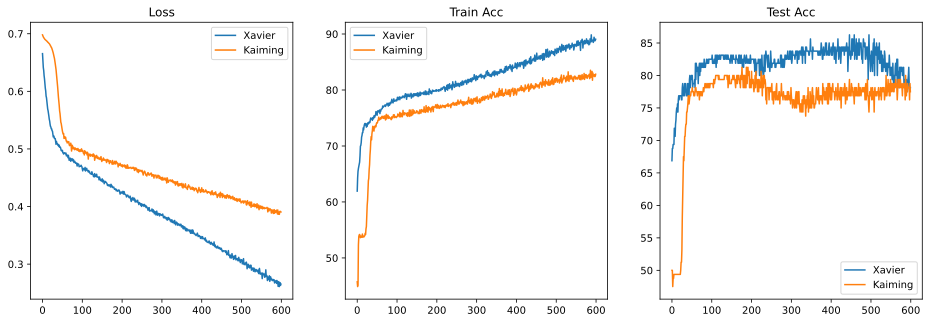

In [97]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
ax[0].plot(lossesX, label="Xavier")
ax[0].plot(lossesK, label="Kaiming")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(trainAccX, label="Xavier")
ax[1].plot(trainAccK, label="Kaiming")
ax[1].legend()
ax[1].set_title("Train Acc")

ax[2].plot(testAccX, label="Xavier")
ax[2].plot(testAccK, label="Kaiming")
ax[2].legend()
ax[2].set_title("Test Acc")

plt.show()

In [90]:
numExp = 10

kaimingData = np.zeros((numExp, 3))
xavierData = np.zeros((numExp, 3)) 

# With Kaiming Initialization
for i in range(numExp):
    ANN, lossFunction, optimizer = getModelWithSetWeights("Kaiming")
    trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)
    kaimingData[i, 0] = torch.mean(losses[:-5]).item()
    kaimingData[i, 1] = np.mean(trainAcc[:-5])
    kaimingData[i, 2] = np.mean(testAcc[:-5])

# With Xavier Initialization
for i in range(numExp):
    ANN, lossFunction, optimizer = getModelWithSetWeights("Xavier")
    trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)

    xavierData[i, 0] = torch.mean(losses[:-5]).item()
    xavierData[i, 1] = np.mean(trainAcc[:-5])
    xavierData[i, 2] = np.mean(testAcc[:-5])

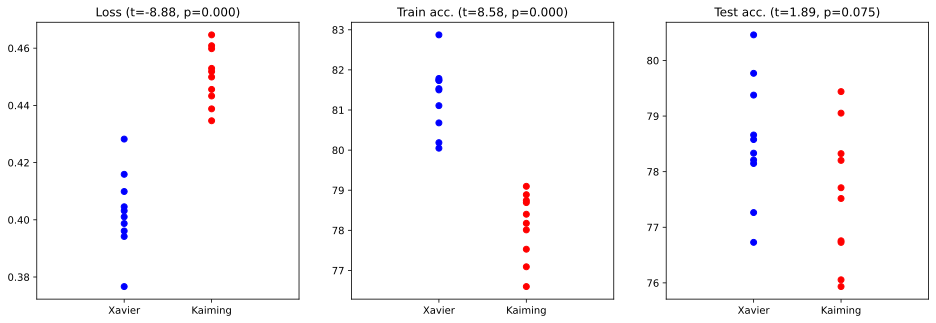

In [92]:
fig, ax = plt.subplots(1,3, figsize=(16,5))

# plot titles
metric = ['Loss','Train acc.','Test acc.']

for i in range(3):
    ax[i].plot(np.zeros(numExp), xavierData[:,i], 'bo')
    ax[i].plot(np.ones(numExp), kaimingData[:,i], 'ro')
    ax[i].set_xlim([-1,2])
    ax[i].set_xticks([0,1])
    ax[i].set_xticklabels(['Xavier','Kaiming'])

    # run a t-test to formalize the comparison
    t,p = stats.ttest_ind(xavierData[:,i], kaimingData[:,i])
    title = '%s (t=%.2f, p=%.3f)' %(metric[i],t,p)

    ax[i].set_title(title)

## The Losses and Training Accuracies are better in case of Xavier and significantly different from Kaiming as p value is less than 0.05. But the test accuracy p value is greater than 0.05 which means that that the test accuracies doesn't have significant difference.